# Constrained Models

AstroPhot models can have very complex constraints which allow for specialized and powerful fitting problems to be solved. Here you will learn how to take advantage of these capabilities.

In [1]:
import astrophot as ap
import numpy as np
import torch
from astropy.io import fits
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

## Range limits

The simplest form of constraint on a parameter is to restrict its range to within some limit. This is done at creation of the variable and you simply indicate the endpoints (non-inclusive) of the limits.

In [4]:
target = ap.image.Target_Image(data = np.zeros((100,100)), center = [0,0], pixelscale = 1)
gal1 = ap.models.AstroPhot_Model(
    name = "galaxy1",
    model_type = "sersic galaxy model",
    parameters = {
        "center": {"value": [0,0], "limits": [[-10,-20], [10,20]]}, # here we set the limits, note it can be different for each value
    },
    target = target,
)

# Now if we try to set a value outside the range we get an error
try:
    gal1["center"].value = [25,25]
except ap.errors.InvalidParameter as e:
    print("got an AssertionError with message: ", e)

got an AssertionError with message:  center has upper limit [10.0, 20.0]


Internal functions in AstroPhot track these limits and so will not go outside those limits under normal circumstances (contact us if you find it happening!). 

## Equality constraints

Another form of constraint is an equality constraint. You can fix one parameter to track another's value so that they will always be equal.

gals:
center: [-25.0, -25.0] +- [0.1, 0.1] [arcsec]
q: 0.9 +- 0.03 [b/a], limits: (0.0, 1.0)
PA: 0.0 +- 0.06 [radians], limits: (0.0, 3.141592653589793), cyclic
n: 2.0 +- 0.05 [none], limits: (0.36, 8.0)
Re: 5.0 [arcsec], limits: (0.0, None)
Ie: 1.0 [log10(flux/arcsec^2)]
center: [25.0, 25.0] +- [0.1, 0.1] [arcsec]
q: 0.9 +- 0.03 [b/a], limits: (0.0, 1.0)
PA: 0.0 +- 0.06 [radians], limits: (0.0, 3.141592653589793), cyclic
Ie: 1.0 [log10(flux/arcsec^2)]


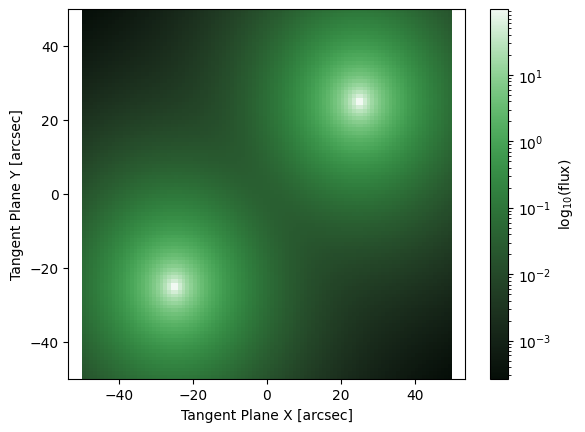

In [8]:
target = ap.image.Target_Image(data = np.zeros((100,100)), center = [0,0], pixelscale = 1)
gal1 = ap.models.AstroPhot_Model(
    name = "galaxy1",
    model_type = "sersic galaxy model",
    parameters = {"center": [-25,-25], "PA": 0, "q": 0.9, "n": 2, "Re": 5, "Ie": 1.},
    target = target,
)
gal2 = ap.models.AstroPhot_Model(
    name = "galaxy2",
    model_type = "sersic galaxy model",
    parameters = {"center": [25,25], "PA": 0, "q": 0.9, "Ie": 1.},
    target = target,
)

# here we set the equality constraint, setting the values for gal2 equal to the parameters of gal1
gal2["n"].value = gal1["n"]
gal2["Re"].value = gal1["Re"]

# we make a group model to use both star models together
gals = ap.models.AstroPhot_Model(
    name = "gals",
    model_type = "group model",
    models = [gal1, gal2],
    target = target,
)

print(gals.parameters)

fig, ax = plt.subplots()
ap.plots.model_image(fig, ax, gals)
plt.show()

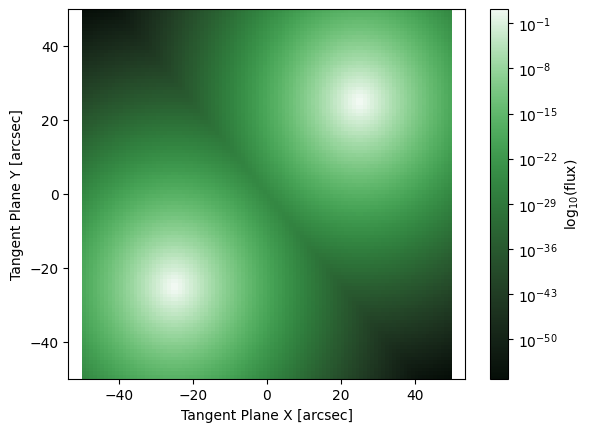

In [10]:
# We can now change a parameter value and both models will change
gal1["n"].value = 1

fig, ax = plt.subplots()
ap.plots.model_image(fig, ax, gals)
plt.show()

Now that these two parameters are linked, optimization algorithms in AstroPhot will take this into account and fit the constrained set of parameters.

## Function constraints

In some situations one may be able to impose a constraint on a set of parameters using some function. Some concrete examples of this include:

- A spatially varying PSF can be forced to obey some smoothing function such as a plane or spline
- The SED of a multiband fit may be constrained to follow some pre-determined form
- An astrometry correction in multi-image fitting can be included for each image to ensure precise alignment

The possibilities with this kind of constraint capability are quite extensive. If you do something creative with these functional constraints please let us know!

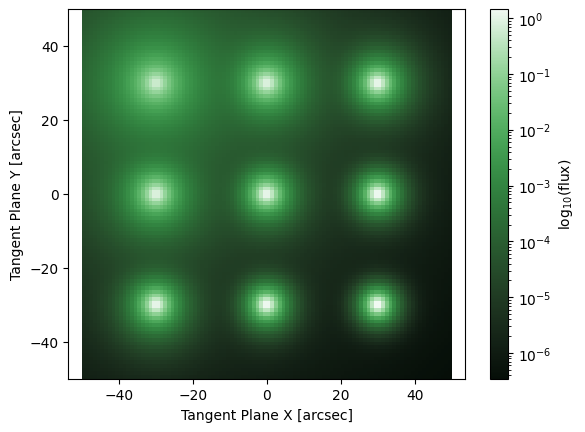

In [13]:
# Here we will demo a spatially varying PSF where the moffat "n" parameter changes across the image
target = ap.image.Target_Image(data = np.zeros((100,100)), center = [0,0], pixelscale = 1)

psf_target = ap.image.PSF_Image(data = np.zeros((25,25)), pixelscale = 1)

# First we make all the star objects
allstars = []
allpsfs = []
for x in [-30,0,30]:
    for y in [-30,0,30]:
        allpsfs.append(
            ap.models.AstroPhot_Model(
                name = "psf",
                model_type = "moffat psf model",
                parameters = {"Rd": 2},
                target = psf_target,
            )
        )
        allstars.append(
            ap.models.AstroPhot_Model(
                name = f"star {x} {y}",
                model_type = "point model",
                parameters = {"center": [x,y], "flux": 1},
                target = target,
                psf = allpsfs[-1],
            )
        )
        allpsfs[-1]["n"].link(allstars[-1]["center"])# see we need to link the center as well so that it can be used in the function

# we link the Rd parameter for all the PSFs so that they are the same
for psf in allpsfs[1:]:
    psf["Rd"].value = allpsfs[0]["Rd"]
        
# next we need the parameters for the spatially varying PSF plane
P_intercept = ap.param.Parameter_Node(
    name = "intercept",
    value = 3,
)
P_slope = ap.param.Parameter_Node(
    name = "slope",
    value = [1/50, -1/50],
)

# next we define the function which takes the parameters as input and returns the value for n
def constrained_moffat_n(params):
    return params["intercept"].value + torch.sum(params["slope"].value * params["center"].value)

# finally we assign this parameter function to the "n" parameter for each moffat
for psf in allpsfs:
    psf["n"].value = constrained_moffat_n
    psf["n"].link(P_intercept)
    psf["n"].link(P_slope)
    
# A group model holds all the stars together
MODEL = ap.models.AstroPhot_Model(
    name = "spatial PSF",
    model_type = "group model",
    models = allstars,
    target = target,
)

fig, ax = plt.subplots()
ap.plots.model_image(fig, ax, MODEL)
plt.show()

See how the PSF parameters vary across the image, this model could now be optimized to fit some data and the parameters of the plane (`intercept` and `slope`) will be optimized alongside everything else to give the best possible optimized parameter values accounting for everything in the image!